In [1]:
# Derived from HW1 Global Alignment

UP = (-1,0)
LEFT = (0, -1)
TOPLEFT = (-1, -1)
ORIGIN = (0, 0)

def traceback_global(v, w, pointers):
    i,j = len(v), len(w)
    new_v = []
    new_w = []
    while True:
        di, dj = pointers[i][j]
        if (di,dj) == LEFT:
            new_v.append('-')
            new_w.append(w[j-1])
        elif (di,dj) == UP:
            new_v.append(v[i-1])
            new_w.append('-')
        elif (di,dj) == TOPLEFT:
            new_v.append(v[i-1])
            new_w.append(w[j-1])
        i, j = i + di, j + dj

        if (i <= 0 and j <= 0):
            break
    return ''.join(new_v[::-1])+'\n'+''.join(new_w[::-1])

def global_align(v, w, delta):
    """
    Returns the score of the maximum scoring alignment of the strings v and w, as well as the actual alignment as
    computed by traceback_global.

    :param: v
    :param: w
    :param: delta
    """
    M = [[0 for j in range(len(w)+1)] for i in range(len(v)+1)]
    pointers = [[ORIGIN for j in range(len(w)+1)] for i in range(len(v)+1)]
    score, alignment = None, None

    for i in range(1, len(v) + 1):
        M[i][0] = M[i - 1][0] + delta[v[i - 1]]['-']
        pointers[i][0] = UP
    for j in range(1, len(w) + 1):
        M[0][j] = M[0][j - 1] + delta['-'][w[j - 1]]
        pointers[0][j] = LEFT

    for i in range(1, len(v) + 1):
        for j in range(1, len(w) + 1):
            match_score = M[i - 1][j - 1] + delta[v[i - 1]][w[j - 1]]
            delete_score = M[i - 1][j] + delta[v[i - 1]]['-']
            insert_score = M[i][j - 1] + delta['-'][w[j - 1]]
            M[i][j] = max(match_score, delete_score, insert_score)

            if M[i][j] == match_score:
                pointers[i][j] = TOPLEFT
            elif M[i][j] == delete_score:
                pointers[i][j] = UP
            else:
                pointers[i][j] = LEFT

    score = M[len(v)][len(w)]
    alignment = traceback_global(v, w, pointers)

    return score, alignment

In [2]:
keys = ['A', 'C', 'T', 'G', '-']
delta = {}
for i in range(len(keys)):
    delta[keys[i]] = {k : v for (k,v) in zip(keys, [1 if keys[i] == keys[j]  else -1 for j in range(len(keys))])}

global_align("TAGATA", "GTAGGCTTAAGGTTA", delta)

(-3, '-TA-G----A---TA\nGTAGGCTTAAGGTTA')

In [3]:
import numpy as np

def hirschberg(i, j, i2, j2, arr, s1, s2):
    to_ret = False
    if arr is None:
        arr = [0] * (j2-j + 1)
        arr[-1] = i2
        to_ret = True

    if j2 - j > 1:
        mid = (j + j2) // 2
        prefix = get_weights(i, j, i2, mid, s1, s2, False)

        suffix = get_weights(i2, j2, i, mid, s1, s2, True)[::-1]

        shift = np.argmax(prefix + suffix)
        best_score = np.max(prefix + suffix)

        i_star = i + shift
        arr[mid] = i_star

        hirschberg(i, j, i_star, mid, arr, s1, s2)
        hirschberg(i_star, mid, i2, j2, arr, s1, s2)

    if to_ret:
      return build_alignment(arr, s1, s2)

def get_weights(i, j, i2, j2, s1, s2, reverse):
    if not reverse:
        weights = np.zeros(i2 - i + 1)
    else:
        weights = np.zeros(i - i2+1)
    for x in range(i, i2):
        xi = x if not reverse else i2 - x - 1
        weights[x - i + 1] = weights[x - i] + delta[s1[xi]]['-']

    for y in range(j, j2):
        yi = y if not reverse else j2 - y - 1
        weights[0] = weights[0] + delta['-'][s2[yi]]
        for x in range(i, i2):
            xi = x if not reverse else i2 - x - 1
            weights[x - i + 1] = max(weights[x - i] + delta[s1[xi]][s2[yi]],
                                    weights[x - i + 1] + delta[s1[xi]]['-'],
                                    weights[x - i] + delta['-'][s2[yi]])
    return weights

def build_alignment(arr, s1, s2):
    o1, o2 = [], []
    ind1, ind2 = 0, 0
    while ind1 < len(s1) or ind2 < len(s2):
        if ind1 + 1 == arr[ind2 + 1]:
            o1.append(s1[ind1])
            o2.append(s2[ind2])
            ind1 += 1
            ind2 += 1
        elif ind1 + 1 < arr[ind2 + 1]:
            o1.append(s1[ind1])
            o2.append('-')
            ind1 += 1
        else:
            o1.append('-')
            o2.append(s2[ind2])
            ind2 += 1
    return ''.join(o1), ''.join(o2)

# Example usage
print(hirschberg(0, 0, 5, 5, None, "ATGTC", "ATCGC"))
print(hirschberg(0, 0, 6, 15, None, "TAGATA", "GTAGGCTTAAGGTTA"))

('AT-GTC', 'ATCG-C')
('-TAG----A---T-A', 'GTAGGCTTAAGGTTA')


In [4]:
import random

def genSequence(n):
    return ''.join(random.choice('ACGT') for _ in range(n))

In [5]:
from random import randint

max_sequence_len = 100
num_reps = 5

dna_sequences = {}
for i in np.arange(1, 1100, 40):
    dna_sequences[i] = []
    for j in range(num_reps):
      dna_sequences[i].append((genSequence(i), genSequence(i)))

In [6]:
!pip install memory_profiler

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import time
import numpy as np

def profile_memory_and_time(func, *args, **kwargs):
    # Warm-up call to the function to ensure any initialization is done outside of measurement
    func(*args, **kwargs)
    time.sleep(0.1)  # wait a bit for the memory to stabilize

    # Record the baseline memory usage before the function call
    baseline_memory_usage = memory_usage(max_usage=True)

    start_time = time.time()
    interval = 0.001
    mem_usage = memory_usage((func, args, kwargs), interval=interval, include_children=True)
    end_time = time.time()

    # Adjust memory usage to reflect only the additional memory used by the function
    adjusted_mem_usage = [mu - baseline_memory_usage for mu in mem_usage]
    adjusted_mem_usage = adjusted_mem_usage[5:]

    # Normalize the memory usage to start from zero for the graph
    min_memory_usage = min(adjusted_mem_usage)
    normalized_mem_usage = [mu - min_memory_usage for mu in adjusted_mem_usage]

    execution_time = end_time - start_time
    peak_memory_usage = max(normalized_mem_usage)
    print(f"Peak memory usage (over baseline): {peak_memory_usage} MiB")
    print(f"Execution time: {execution_time} seconds")

    # Adjust the time vector to account for the discarded measurements
    time_vector = np.linspace(0, execution_time, num=len(normalized_mem_usage))

    fig = plt.figure(figsize=(10, 4))
    plt.plot(time_vector, normalized_mem_usage)
    plt.title(f'Memory usage over time for function {func.__name__}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Memory usage (MiB)')
    plt.show()  # Display the plot

    return fig

Peak memory usage (over baseline): 6.24609375 MiB
Execution time: 1.026000738143921 seconds


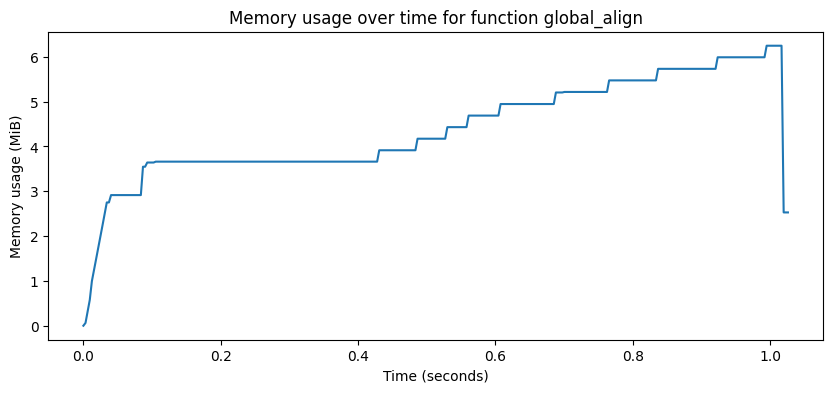

In [8]:
v = genSequence(500)  # Example sequence v
w = genSequence(500)   # Example sequence w

# Profile the global_align function
fig_needleman = profile_memory_and_time(global_align, v, w, delta)
fig_needleman.show()

Peak memory usage (over baseline): 0.31640625 MiB
Execution time: 1.2248413562774658 seconds


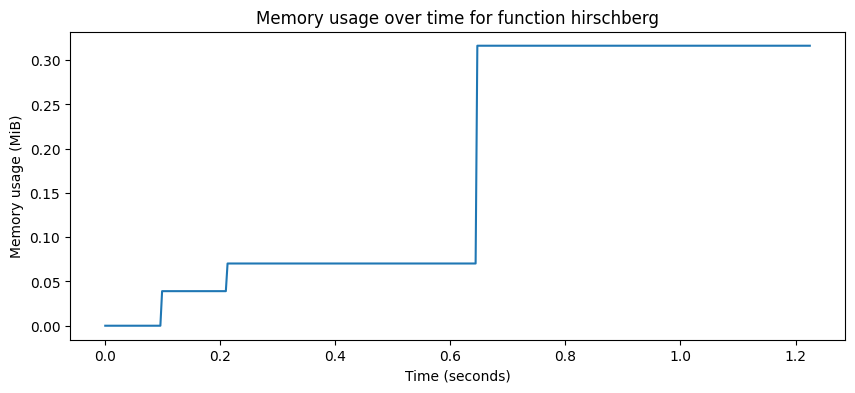

In [9]:
fig_hirschberg = profile_memory_and_time(hirschberg, 0, 0, len(v), len(w), None, v, w)
fig_hirschberg.show()

In [10]:
def calc_mem_time_noplot(func, *args, **kwargs):
    # Warm-up call to the function
    func(*args, **kwargs)

    # Measure baseline memory usage just before the function call
    baseline_memory_usage = memory_usage(max_usage=True)

    start_time = time.time()
    interval = 0.001
    # Measure memory usage during the function call
    mem_usage = memory_usage((func, args, kwargs), interval=interval, include_children=True)
    end_time = time.time()

    # Adjust memory usage to reflect the additional memory used by the function
    adjusted_mem_usage = [mu - baseline_memory_usage for mu in mem_usage]

    # Calculate peak memory usage
    peak_memory_usage = max(adjusted_mem_usage)

    execution_time = end_time - start_time
    return peak_memory_usage, execution_time


nw_mem_usages = []
nw_exec_times = []
for curr_seqs in dna_sequences.values():
    total_mem = 0
    total_exec = 0
    for (v,w) in curr_seqs:
        curr_mem_usage, curr_exec_time = calc_mem_time_noplot(global_align, v, w, delta)
        total_mem += curr_mem_usage
        total_exec += curr_exec_time
    nw_mem_usages.append(total_mem/len(curr_seqs))
    nw_exec_times.append(total_exec/len(curr_seqs))

seq_lens = dna_sequences.keys()

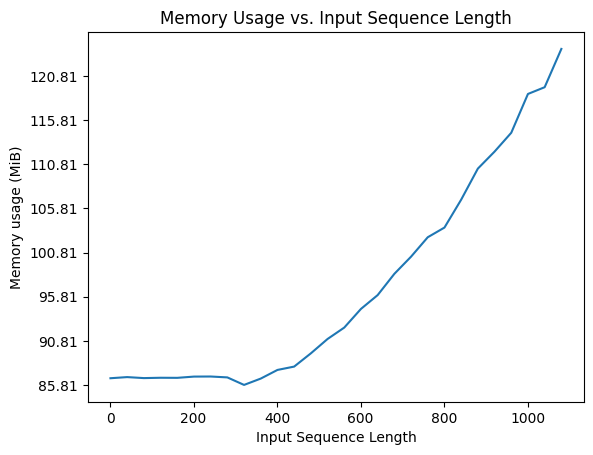

In [11]:
plt.plot(seq_lens, nw_mem_usages)
plt.title(f'Memory Usage vs. Input Sequence Length')
plt.xlabel('Input Sequence Length')
plt.xticks(np.arange(0, max(seq_lens)+1, 200))
plt.ylabel('Memory usage (MiB)')
plt.yticks(np.arange(min(nw_mem_usages), max(nw_mem_usages), 5))
plt.show()

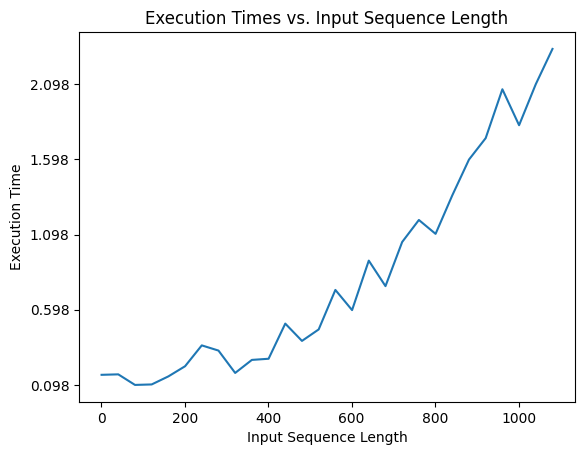

In [12]:
plt.plot(seq_lens, nw_exec_times)
plt.title(f'Execution Times vs. Input Sequence Length')
plt.xlabel('Input Sequence Length')
plt.xticks(np.arange(0, max(seq_lens)+1, 200))
plt.ylabel('Execution Time')
plt.yticks(np.arange(min(nw_exec_times), max(nw_exec_times), 0.5))
plt.show()

In [ ]:
h_mem_usages = []
h_exec_times = []

for curr_seqs in dna_sequences.values():
    total_mem = 0
    total_exec = 0
    for (v,w) in curr_seqs:
        curr_mem_usage, curr_exec_time = calc_mem_time_noplot(hirschberg, 0, 0, len(v), len(w), None, v, w)
        total_mem += curr_mem_usage
        total_exec += curr_exec_time
    h_mem_usages.append(total_mem/len(curr_seqs))
    h_exec_times.append(total_exec/len(curr_seqs))

seq_lens = dna_sequences.keys()

In [ ]:
plt.plot(seq_lens, h_mem_usages)
plt.title(f'Memory Usage vs. Input Sequence Length')
plt.xlabel('Input Sequence Length')
plt.xticks(np.arange(0, max(seq_lens)+1, 200))
plt.ylabel('Memory usage (MiB)')
plt.yticks(np.arange(min(h_mem_usages), max(h_mem_usages), 0.1))
plt.show()

In [ ]:
plt.plot(seq_lens, h_exec_times)
plt.title(f'Execution Times vs. Input Sequence Length')
plt.xlabel('Input Sequence Length')
plt.xticks(np.arange(0, max(seq_lens)+1, 200))
plt.ylabel('Execution Time')
plt.yticks(np.arange(min(h_exec_times), max(h_exec_times), 0.5))
plt.show()